In [2]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss
from network import synthetic_graph, get_alphas
from related_works import colearning, lafond_FW
from optimization import graph_discovery_sparse, regularized_local_FW, local_FW, global_regularized_local_FW, gd_reg_local_FW, centralized_FW
from utils import generate_models, generate_moons, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# set graph of nodes with local personalized data
NB_ITER = 15000
K = 100
D = 20
n = 200
NOISE_R = 0.05
random_state = 2017
MU = 1
BETA = 10

checkevery = 100

V, theta_true, cluster_indexes = generate_models(nb_clust=1, nodes_per_clust=K, random_state=random_state)
_, X, Y, X_test, Y_test, max_nb_instances = generate_moons(V, theta_true, D, random_state=random_state, sample_error_rate=NOISE_R)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, V, theta_true, max_nb_instances)

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D+1, min_v=vmin, max_v=vmax)

results = {}

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
}

colors = {
    "Dada": "b",
    "global l1 Adaboost": "g",
    "purely local models": "k",
    "global-local mixture": "y",
    "personalized linear": "m",    
}

In [6]:
nodes_copy = deepcopy(nodes)
results["Dada"] = regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, mu=MU, monitors=monitors, checkevery=checkevery)

In [7]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=200, monitors={})
results["global l1 Adaboost"] = {}
results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=200, monitors={})
results["purely local models"] = {}
results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

global_nodes = deepcopy(nodes)
global_regularized_local_FW(global_nodes, base_clfs, beta=BETA, nb_iter=200, monitors={})
results["global-local mixture"] = {}
results["global-local mixture"]["train-accuracy"] = central_train_accuracy(global_nodes)
results["global-local mixture"]["test-accuracy"] = central_test_accuracy(global_nodes)

results["personalized linear"], clf_colearning = colearning(K, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, similarities, mu=MU, max_samples_per_node=max_nb_instances, checkevery=10)

# Accuracy and Convergence

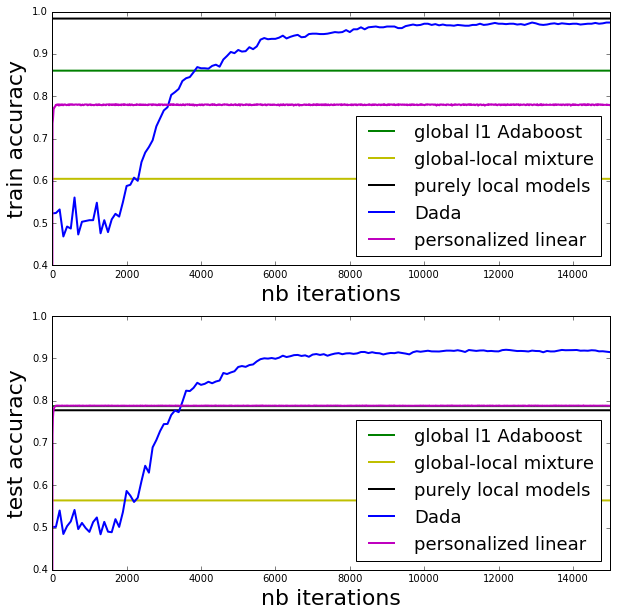

In [8]:
plt.figure(1, figsize=(10, 10))

max_iter = NB_ITER
plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    try:
        if k == "Dada":
            c = 100
        else:
            c = 10
        plt.plot([i*c for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label='{}'.format(k), color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=18)

plt.subplot(212)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    try:
        if k == "Dada":
            c = 100
        else:
            c = 10
        plt.plot([i*c for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label='{}'.format(k), color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=18)

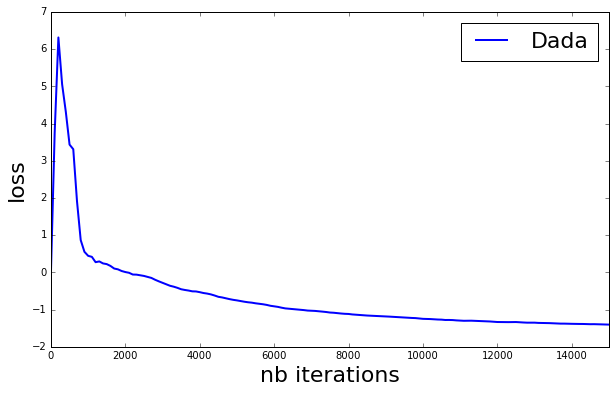

In [9]:
# convergence

plt.figure(1, figsize=(10, 6))

plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('loss', fontsize=22)
plt.xlim(0, NB_ITER)
for k, r_list in results.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['loss'] for r in r_list], label='{}'.format(k), color=colors[k], linewidth=2)
    except:
        pass

plt.legend(loc='upper right', fontsize=22)

# Communication

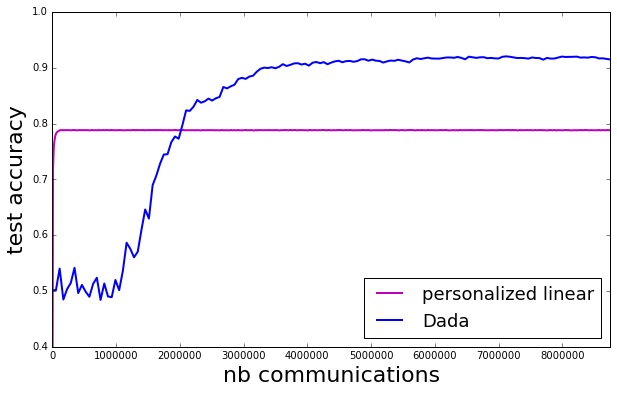

In [10]:
from math import log

Z = 32
# test accuracy vs communication
linear_com = 2*D*Z
regularized_com = np.sum(adj_matrix)/K *(Z + log(n))

x_linear = [linear_com*i*10 for i in range(len(results['personalized linear']))]
x_regularized = [regularized_com*i*100 for i in range(len(results['Dada']))]

plt.figure(1, figsize=(10, 6))

plt.xlabel('nb communications', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)

plt.plot(x_linear, [r['test-accuracy'] for r in results['personalized linear']], label='personalized linear', color=colors['personalized linear'], linewidth=2)
plt.plot(x_regularized, [r['test-accuracy'] for r in results['Dada']], label='Dada', color=colors['Dada'], linewidth=2)

plt.xlim(0, min(max(x_regularized), max(x_linear)))
plt.ylim(0.4, 1)
plt.legend(loc="lower right", fontsize=18)

# Graph Discovery

### study impact of pace of iterations for learning W

In [11]:
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
}

# graph discovery
min_k = 15
results_gd = {}

results_gd["ground-truth graph"] = results["Dada"]
results_gd["purely local models"] = results["purely local models"]

# initialize with local models
init_w = graph_discovery_sparse(local_nodes, min_k)
for p in [200, 800, 1400]:

    gd_nodes = deepcopy(nodes)
    results_gd["graph discovery t_w={}".format(p)] = gd_reg_local_FW(gd_nodes, base_clfs, init_w, gd_method={"name":"laplacian", "pace_gd": p, "args":(min_k)}, beta=BETA, mu=0.1, reset_step=False, nb_iter=10000, monitors=monitors, checkevery=checkevery)

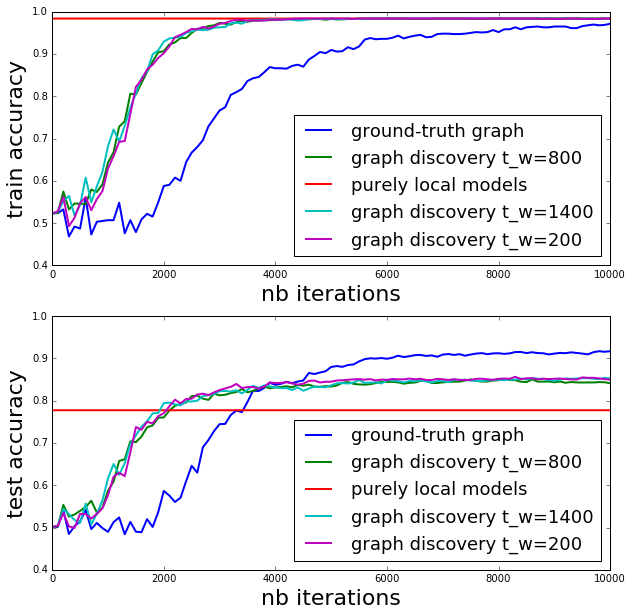

In [12]:
NB_ITER=10000
plt.figure(1, figsize=(10, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, NB_ITER)
plt.ylim(0.4, 1)

for k, r_list in results_gd.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label='{}'.format(k), linewidth=2)
        
plt.legend(loc='lower right', fontsize=18)

plt.subplot(212)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, NB_ITER)
plt.ylim(0.4, 1)

for k, r_list in results_gd.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label='{}'.format(k), linewidth=2)

plt.legend(loc='lower right', fontsize=18)



### study impact of minimal number of neighbors

In [13]:
# different minimal number of neighbors
results_gd_nei = {}

results_gd_nei["graph discovery q={}".format(min_k)] = results_gd["graph discovery t_w=800"]
results_gd_nei["ground-truth graph"] = results["Dada"]
results_gd_nei["purely local models"] = results["purely local models"]
# initialize with local models
local_alphas = get_alphas(local_nodes)
    
for i in [1, 5, 10]:

    gd_nodes = deepcopy(nodes)
    results_gd_nei["graph discovery q={}".format(i)] = gd_reg_local_FW(gd_nodes, base_clfs, init_w, gd_method={"name":"laplacian", "pace_gd": 800, "args":(i)}, beta=BETA, mu=0.1, reset_step=False, nb_iter=NB_ITER, monitors=monitors, checkevery=100)

(0.4, 1)

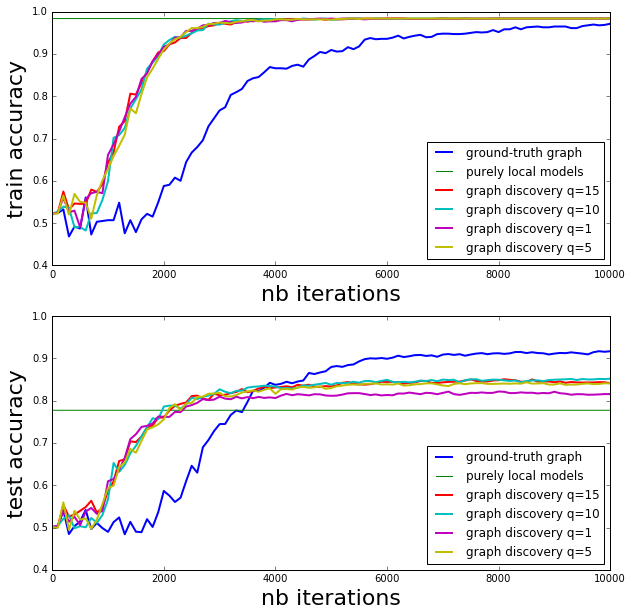

In [14]:
max_k = 8
plt.figure(1, figsize=(10, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, NB_ITER)
plt.ylim(0.4, 1)
for k, r_list in results_gd_nei.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label='{}'.format(k))
        
plt.legend(loc='lower right', fontsize=12)

plt.subplot(212)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, NB_ITER)

for k, r_list in results_gd_nei.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label='{}'.format(k), linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label='{}'.format(k))

plt.legend(loc='lower right', fontsize=12)
plt.ylim(0.4, 1)
